In [13]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Preprocess

In [14]:
class Prepare:
    def __init__(self, train, test, scaler):
        self.train = train
        self.test = test
        self.scaler = scaler

    def preprocess(self):
        encoder = LabelEncoder()
        cat_features = 'Sex'
        target = 'Rings'
        self.train.drop(columns=['id'], axis=1, inplace=True)
        self.ids = self.test['id']  
        self.test.drop(columns=['id'], axis=1, inplace=True)
        continuous_features = [col for col in self.train.columns if col not in [cat_features, target]]
        self.train[cat_features] = encoder.fit_transform(self.train[cat_features])
        self.test[cat_features] = encoder.fit_transform(self.test[cat_features])
        self.train[continuous_features] = self.scaler.fit_transform(self.train[continuous_features])
        self.test[continuous_features] = self.scaler.transform(self.test[continuous_features])

        X = self.train.drop(columns=[target], axis=1)
        y = self.train[target]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=24)
        return X_train, X_val, y_train, y_val

# Model 

In [15]:
class Dense(nn.Module):
    def __init__(self, input_shape):
        super(Dense, self).__init__()
        self.fcl1 = nn.Linear(input_shape, 64)
        self.fcl2 = nn.Linear(64, 32)
        self.fcl3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fcl1(x))
        x = self.relu(self.fcl2(x))
        x = self.fcl3(x)
        return x

# Training

In [16]:
def train(model, X_train, X_val, y_train, y_val, batch_size, num_epochs):
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize variables for early stopping
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 7
    initial_lr = 0.006
    lr_step_size = 6
    lr_gamma = 0.1
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

    for epoch in range(num_epochs):
        model.train()
        avg_train_loss = []
        for i, (train_batch, val_batch) in enumerate(tqdm(train_loader)):
            train_batch = train_batch.to(device)
            val_batch = val_batch.to(device)
            optimizer.zero_grad()
            output = model(train_batch)
            loss = criterion(output, val_batch.view(-1, 1))
            loss.backward()
            optimizer.step()
            avg_train_loss.append(loss.item())
        avg_train_loss = np.mean(avg_train_loss)

        model.eval()
        avg_val_loss = []
        with torch.no_grad():
            for j, (train_batch, val_batch) in enumerate(tqdm(val_loader)):
                train_batch, val_batch = train_batch.to(device), val_batch.to(device)
                output = model(train_batch)
                loss = criterion(output, val_batch.view(-1, 1))
                avg_val_loss.append(loss.item())
        avg_val_loss = np.mean(avg_val_loss)

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        # Apply learning rate scheduling
        scheduler.step()

        # Append the losses for this epoch
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    # Create a DataFrame to store the losses
    loss_df = pd.DataFrame({'val_loss': val_losses, 'train_loss': train_losses})

    # Plot the losses
    plt.plot(loss_df.index + 1, loss_df['train_loss'], label='Train Loss')
    plt.plot(loss_df.index + 1, loss_df['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    model.load_state_dict(best_model_state)

    with torch.no_grad():
        model.eval()
        predictions = model(X_val_tensor.to(device)).cpu().numpy()
        RMSE = np.sqrt(mean_squared_error(y_val_tensor.to(device).view(-1, 1), predictions))

    return model, RMSE

# Inference

In [19]:
def inference(model, prepare_instance):
    ids = prepare_instance.ids
    preprocessed_test_data = prepare_instance.test
    test_tensor = torch.tensor(preprocessed_test_data.values, dtype=torch.float32)
    
    with torch.no_grad():
        model.eval()
        predictions = model(test_tensor.to(device)).cpu().numpy().reshape(-1, 1)  # Flatten predictions
    
    submission_df = pd.DataFrame({'id': ids, 'Rings': predictions.flatten()})  # Flatten predictions
    return submission_df

# Instantiation

100%|██████████| 149/149 [00:00<00:00, 714.65it/s]


Epoch [1/100], Train Loss: 6.1486, Val Loss: 3.7675


100%|██████████| 149/149 [00:00<00:00, 589.38it/s]


Epoch [2/100], Train Loss: 3.7288, Val Loss: 3.6752


100%|██████████| 149/149 [00:00<00:00, 678.34it/s]


Epoch [3/100], Train Loss: 3.7255, Val Loss: 3.7433


100%|██████████| 149/149 [00:00<00:00, 702.71it/s]


Epoch [4/100], Train Loss: 3.7225, Val Loss: 3.6723


100%|██████████| 149/149 [00:00<00:00, 689.66it/s]


Epoch [5/100], Train Loss: 3.6682, Val Loss: 3.6100


100%|██████████| 149/149 [00:00<00:00, 697.95it/s]


Epoch [6/100], Train Loss: 3.6691, Val Loss: 3.6157


100%|██████████| 149/149 [00:00<00:00, 699.82it/s]


Epoch [7/100], Train Loss: 3.5484, Val Loss: 3.5543


100%|██████████| 149/149 [00:00<00:00, 694.72it/s]


Epoch [8/100], Train Loss: 3.5386, Val Loss: 3.5559


100%|██████████| 149/149 [00:00<00:00, 698.55it/s]


Epoch [9/100], Train Loss: 3.5421, Val Loss: 3.5654


100%|██████████| 149/149 [00:00<00:00, 701.62it/s]


Epoch [10/100], Train Loss: 3.5375, Val Loss: 3.5678


100%|██████████| 149/149 [00:00<00:00, 684.63it/s]


Epoch [11/100], Train Loss: 3.5341, Val Loss: 3.5666


100%|██████████| 149/149 [00:00<00:00, 692.38it/s]


Epoch [12/100], Train Loss: 3.5359, Val Loss: 3.5499


100%|██████████| 149/149 [00:00<00:00, 698.14it/s]


Epoch [13/100], Train Loss: 3.5182, Val Loss: 3.5383


100%|██████████| 149/149 [00:00<00:00, 704.55it/s]


Epoch [14/100], Train Loss: 3.5174, Val Loss: 3.5379


100%|██████████| 149/149 [00:00<00:00, 710.02it/s]


Epoch [15/100], Train Loss: 3.5163, Val Loss: 3.5384


100%|██████████| 149/149 [00:00<00:00, 702.71it/s]


Epoch [16/100], Train Loss: 3.5141, Val Loss: 3.5376


100%|██████████| 149/149 [00:00<00:00, 712.40it/s]


Epoch [17/100], Train Loss: 3.5133, Val Loss: 3.5405


100%|██████████| 149/149 [00:00<00:00, 694.79it/s]


Epoch [18/100], Train Loss: 3.5151, Val Loss: 3.5368


100%|██████████| 149/149 [00:00<00:00, 706.35it/s]


Epoch [19/100], Train Loss: 3.5132, Val Loss: 3.5369


100%|██████████| 149/149 [00:00<00:00, 708.46it/s]


Epoch [20/100], Train Loss: 3.5137, Val Loss: 3.5371


100%|██████████| 149/149 [00:00<00:00, 712.04it/s]


Epoch [21/100], Train Loss: 3.5106, Val Loss: 3.5371


100%|██████████| 149/149 [00:00<00:00, 714.45it/s]


Epoch [22/100], Train Loss: 3.5144, Val Loss: 3.5372


100%|██████████| 149/149 [00:00<00:00, 713.50it/s]


Epoch [23/100], Train Loss: 3.5190, Val Loss: 3.5373


100%|██████████| 149/149 [00:00<00:00, 736.94it/s]


Epoch [24/100], Train Loss: 3.5132, Val Loss: 3.5376


100%|██████████| 149/149 [00:00<00:00, 703.13it/s]


Early stopping at epoch 25


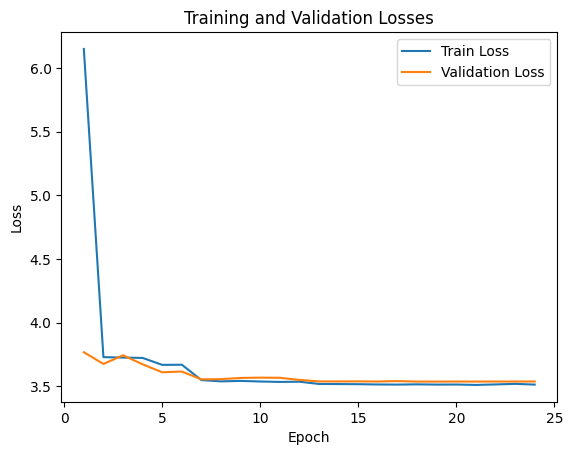

Validation RMSE: 1.8817074


,id,Rings
0,90615,9.685292
1,90616,9.492907
2,90617,10.193849
3,90618,9.925019
4,90619,7.466869
...,...,...
60406,151021,6.433720
60407,151022,9.400597
60408,151023,11.548954
60409,151024,13.021736


In [20]:
# Load data
train_data = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

# Prepare data
scaler = PowerTransformer()
prep = Prepare(train_data, test_data, scaler)
X_train, X_val, y_train, y_val = prep.preprocess()

# Create and train model
model = Dense(input_shape=X_train.shape[1])
trained_model, val_rmse = train(model, X_train, X_val, y_train, y_val, 122, 100)

print("Validation RMSE:", val_rmse)

submission_df = inference(trained_model, prep)
submission_df.to_csv('submission.csv', index=False)
submission_df